# Sentiment Analysis for Amazon Reviews

## Necessary imports and configurations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
!pip install transformers

In [3]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.3 MB/s eta 0:00:00


The dataset was downloaded and uplodaed on drive to import it. The dataset is Amazon Food Reviws Dataset found on Kaggle. (https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/)

In [4]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/gdrive')
zip_file_path = "/content/gdrive/MyDrive/ReviewsDataset/archive.zip"
extracted_folder_path = '/content/'
# Unzip the file using the command line
!unzip "$zip_file_path" -d "$extracted_folder_path"

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/ReviewsDataset/archive.zip
  inflating: /content/Reviews.csv    
  inflating: /content/database.sqlite  
  inflating: /content/hashes.txt     



##Exploring Dataset

In this section, our focus will be on the exploration of the Reviews Dataset. The goal is to gain insights about the score distribution within this dataset. We took a slice of the data 100000 instances to work with as an example.

In [5]:
df = pd.read_csv('/content/Reviews.csv')
df = df.sample(n=100000, random_state=45).reset_index(drop=True)

In [6]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,300666,B0079FMZ48,AVZEKXW4I5KVA,angel,1,1,5,1299024000,jamaica heat,I have used this product before and found it t...
1,167486,B0001FR0BQ,A394DL0WYMWW7W,Evert Veldhuis,0,1,5,1284076800,I love the product and will order more soon,The product arrived a bit later than expected ...
2,313461,B000EMK4H8,A3LWBK6V6ZSWNS,"Highland Fling ""Heather""",1,1,5,1161993600,To Die For Good!,"I never eat this stuff, usually but Walmart ha..."
3,7590,B000CQ6KSI,A107RA9MLD5HQ0,A. Stults,0,0,3,1202083200,"All natural, but bland","It's all natural, no artificial color, no weir..."
4,48969,B001E5E0T2,A1F75DCJLBKBVT,mh21,0,1,5,1204070400,Good product,I've not actually used any other filter paper ...


In [7]:
df['Text'].values[0]

'I have used this product before and found it to be the best product for jerk chicken. I could not find this product anywhere until my sister suggested I look on Amazon. There is nothing like it. It has a very unique taste.  I have tried other products out there and nothing compares to Busha Brownes Authentic Jerk Seasoning. I find myself wanting to go to jamaica and drink some rum and have jerk chicken.'

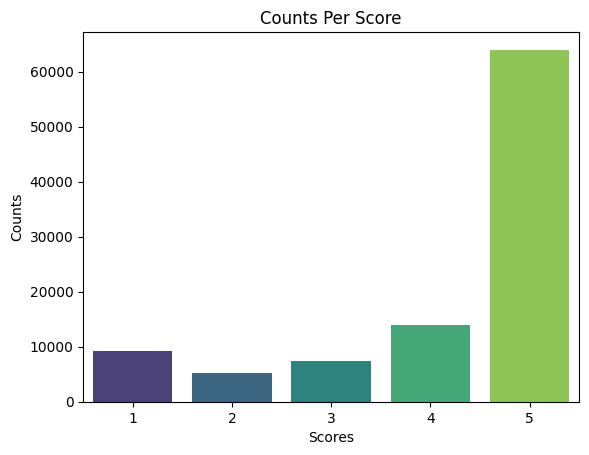

In [8]:
reviews_counts = df['Score'].value_counts().to_dict()
sns.barplot(x=list(reviews_counts.keys()), y=list(reviews_counts.values()), palette="viridis")

# Adding labels and title
plt.xlabel('Scores')
plt.ylabel('Counts')
plt.title('Counts Per Score')

# Show the plot
plt.show()

## Transform Data
In this section, we aim to simplify the classification process. Scores exceeding 3 will be categorized as positive, a score of 3 will be considered neutral, and any score below 3 will be labeled as negative sentiment.

In [9]:
def assign_positive_negative_neutral_score(row):
  if row['Score'] > 3:
    return 'positive'
  elif row['Score'] == 3:
    return 'neutral'
  else:
    return 'negative'

In [10]:
df['Score'] = df.apply(assign_positive_negative_neutral_score, axis=1)

In [11]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,300666,B0079FMZ48,AVZEKXW4I5KVA,angel,1,1,positive,1299024000,jamaica heat,I have used this product before and found it t...
1,167486,B0001FR0BQ,A394DL0WYMWW7W,Evert Veldhuis,0,1,positive,1284076800,I love the product and will order more soon,The product arrived a bit later than expected ...
2,313461,B000EMK4H8,A3LWBK6V6ZSWNS,"Highland Fling ""Heather""",1,1,positive,1161993600,To Die For Good!,"I never eat this stuff, usually but Walmart ha..."
3,7590,B000CQ6KSI,A107RA9MLD5HQ0,A. Stults,0,0,neutral,1202083200,"All natural, but bland","It's all natural, no artificial color, no weir..."
4,48969,B001E5E0T2,A1F75DCJLBKBVT,mh21,0,1,positive,1204070400,Good product,I've not actually used any other filter paper ...
...,...,...,...,...,...,...,...,...,...,...
99995,389254,B000FDDEV4,AE05T7QGYYBB4,"C. Stokes ""big fan""",5,6,positive,1173312000,very healthy and easy,I replaced all rice in my meals with whole whe...
99996,139319,B004VLV46S,A1QQLC9V6LRTA7,Frank C. Zimmerman,2,2,positive,1320278400,"Excellent product, great price.","I've tried various kinds of Carob powder, from..."
99997,397730,B001EYUE5M,A3T3W24FV61W94,JudithP.,1,1,negative,1345161600,Dissapionted,Very dissapionted in this oder.Have had this c...
99998,482367,B0018KLPFK,A3S1YI6MC7832G,Reviewer,3,3,positive,1269648000,"Good, but Flavor Names Not Always Appropriate","I've grown to really like these bars, but the ..."


Check distribution of Scores after transformation


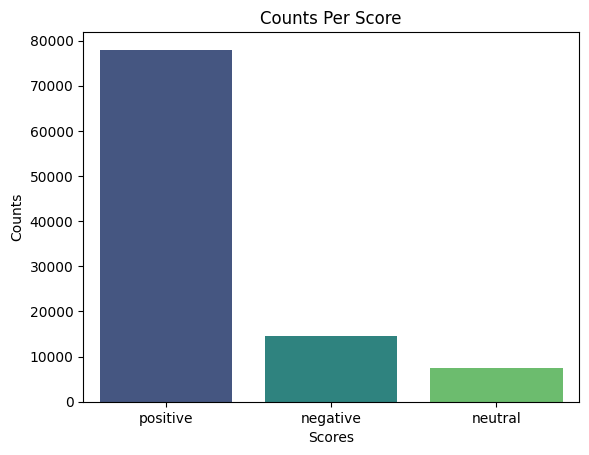

In [12]:
reviews_counts = df['Score'].value_counts().to_dict()
sns.barplot(x=list(reviews_counts.keys()), y=list(reviews_counts.values()), palette="viridis")

# Adding labels and title
plt.xlabel('Scores')
plt.ylabel('Counts')
plt.title('Counts Per Score')

# Show the plot
plt.show()

## Preprocessing text

Each text from the dataset will be pre-processed by removing symbols and extra white-spaces from it then converting its letters to lowercase.

In [13]:
def preprocess_text(row):
    symbols_to_remove = r'"#$%&\'()*+,-/:;<=>@[\]^_`{|}~'
    cleaned_text = re.sub(f'[{re.escape(symbols_to_remove)}]', '', row['Text'])
    processed_text = cleaned_text.replace('...', '.').replace('?', '.').replace('!', '.')
    processed_multiple_spaces = re.sub(r'\s+', ' ', processed_text)

    return processed_multiple_spaces.lower()

In [14]:
df['Text'] = df.apply(preprocess_text, axis=1)

In [15]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,300666,B0079FMZ48,AVZEKXW4I5KVA,angel,1,1,positive,1299024000,jamaica heat,i have used this product before and found it t...
1,167486,B0001FR0BQ,A394DL0WYMWW7W,Evert Veldhuis,0,1,positive,1284076800,I love the product and will order more soon,the product arrived a bit later than expected ...
2,313461,B000EMK4H8,A3LWBK6V6ZSWNS,"Highland Fling ""Heather""",1,1,positive,1161993600,To Die For Good!,i never eat this stuff usually but walmart had...
3,7590,B000CQ6KSI,A107RA9MLD5HQ0,A. Stults,0,0,neutral,1202083200,"All natural, but bland",its all natural no artificial color no weird i...
4,48969,B001E5E0T2,A1F75DCJLBKBVT,mh21,0,1,positive,1204070400,Good product,ive not actually used any other filter paper s...
...,...,...,...,...,...,...,...,...,...,...
99995,389254,B000FDDEV4,AE05T7QGYYBB4,"C. Stokes ""big fan""",5,6,positive,1173312000,very healthy and easy,i replaced all rice in my meals with whole whe...
99996,139319,B004VLV46S,A1QQLC9V6LRTA7,Frank C. Zimmerman,2,2,positive,1320278400,"Excellent product, great price.",ive tried various kinds of carob powder from r...
99997,397730,B001EYUE5M,A3T3W24FV61W94,JudithP.,1,1,negative,1345161600,Dissapionted,very dissapionted in this oder.have had this c...
99998,482367,B0018KLPFK,A3S1YI6MC7832G,Reviewer,3,3,positive,1269648000,"Good, but Flavor Names Not Always Appropriate",ive grown to really like these bars but the fl...


## Bag of words approach (VADER)

In [35]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [64]:
sia.polarity_scores('I am glad')

{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.4588}

In [65]:
sia.polarity_scores('I am not that glad')

{'neg': 0.453, 'neu': 0.547, 'pos': 0.0, 'compound': -0.357}

In [66]:
def classify_vader_sentiment(compound):
  if compound >=  0.05:
    return 'positive'
  elif compound <= - 0.05:
    return 'negative'
  else:
    return 'neutral'

In [67]:
res = []
for i, row in tqdm(df.iterrows(), total=len(df)):
  res.append(classify_vader_sentiment((sia.polarity_scores(row['Text'])['compound'])))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [69]:
vaders_scores_df = df
vaders_scores_df['Score Vaders'] = res

In [70]:
vaders_scores_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score Vaders
0,300666,B0079FMZ48,AVZEKXW4I5KVA,angel,1,1,positive,1299024000,jamaica heat,i have used this product before and found it t...,negative
1,167486,B0001FR0BQ,A394DL0WYMWW7W,Evert Veldhuis,0,1,positive,1284076800,I love the product and will order more soon,the product arrived a bit later than expected ...,positive
2,313461,B000EMK4H8,A3LWBK6V6ZSWNS,"Highland Fling ""Heather""",1,1,positive,1161993600,To Die For Good!,i never eat this stuff usually but walmart had...,positive
3,7590,B000CQ6KSI,A107RA9MLD5HQ0,A. Stults,0,0,neutral,1202083200,"All natural, but bland",its all natural no artificial color no weird i...,positive
4,48969,B001E5E0T2,A1F75DCJLBKBVT,mh21,0,1,positive,1204070400,Good product,ive not actually used any other filter paper s...,positive
...,...,...,...,...,...,...,...,...,...,...,...
99995,389254,B000FDDEV4,AE05T7QGYYBB4,"C. Stokes ""big fan""",5,6,positive,1173312000,very healthy and easy,i replaced all rice in my meals with whole whe...,positive
99996,139319,B004VLV46S,A1QQLC9V6LRTA7,Frank C. Zimmerman,2,2,positive,1320278400,"Excellent product, great price.",ive tried various kinds of carob powder from r...,positive
99997,397730,B001EYUE5M,A3T3W24FV61W94,JudithP.,1,1,negative,1345161600,Dissapionted,very dissapionted in this oder.have had this c...,neutral
99998,482367,B0018KLPFK,A3S1YI6MC7832G,Reviewer,3,3,positive,1269648000,"Good, but Flavor Names Not Always Appropriate",ive grown to really like these bars but the fl...,positive


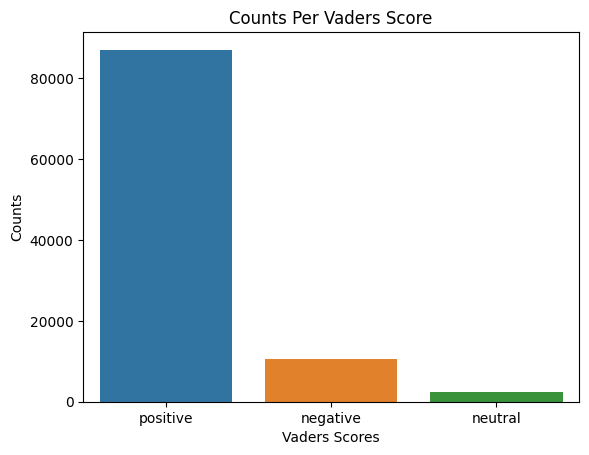

In [71]:
counts = vaders_scores_df['Score Vaders'].value_counts()
sns.barplot(x= counts.index, y= counts.values)

# Adding labels and title
plt.xlabel('Vaders Scores')
plt.ylabel('Counts')
plt.title('Counts Per Vaders Score')

# Show the plot
plt.show()

VADER cannot capture neutral texts efficiently. It is noticed by the drop of the total number of neutral texts in the dataset.

## Text-To-Text Model (T5)


### Configuration

Loading pre-training model from Hugging Face Hub.

In [73]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Adafactor

model_name = "t5-base"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [74]:
model.config.vocab_size

32128

Split data into two parts: training data and test data.

In [75]:
#from sklearn.model_selection import train_test_split
# Assuming 'df' is your DataFrame
split_percentage = 0.8

# Calculate the split index
split_index = int(len(df) * split_percentage)

# Split the data
train_data = df['Text'][:split_index]
test_data = df['Text'][split_index:].reset_index(drop=True)
train_labels = df['Score'][:split_index]
test_labels = df['Score'][split_index:].reset_index(drop=True)

Creating our own Custom Dataset

In [76]:
from torch.utils.data import Dataset, DataLoader
import torch

class ReviewsDataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length


  def __len__(self):
    return len(self.texts)


  def __getitem__(self, index):
    try:
        encoding = self.tokenizer(
            self.texts[index],
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        labels = tokenizer(self.labels[index] + " </s>", return_tensors='pt', max_length=2)
        input_labels = labels['input_ids'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_labels
        }
    except Exception as e:
        print(f"Error at index {index}: {str(e)}")
        raise

Split Training Data and Test Data into batches for batch processing.

In [77]:
train_dataset = ReviewsDataset(train_data, train_labels, tokenizer, 100)
test_dataset = ReviewsDataset(test_data, test_labels, tokenizer, 100)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Choosing optimizer and number of training epochs.

In [78]:
optimizer = Adafactor(model.parameters(), lr=0.005, scale_parameter=True, relative_step=False)
num_epochs = 2

### Training

In [79]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print_interval = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    counter = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        counter += 1

        # Print the loss every print_interval batches
        if counter % print_interval == 0:
            average_loss = total_loss / print_interval
            print("============================================")
            print(f"Epoch {epoch + 1}, Batch {counter}, Average Loss: {average_loss}")
            total_loss = 0.0  # Reset total_loss for the next set of batches

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1, Batch 100, Average Loss: 0.485085559040308
Epoch 1, Batch 200, Average Loss: 0.20042918048799038
Epoch 1, Batch 300, Average Loss: 0.1841977509856224
Epoch 1, Batch 400, Average Loss: 0.18620118200778962
Epoch 1, Batch 500, Average Loss: 0.18313375633209944
Epoch 1, Batch 600, Average Loss: 0.18394254816696048
Epoch 1, Batch 700, Average Loss: 0.1751143003255129
Epoch 1, Batch 800, Average Loss: 0.16928139373660087
Epoch 1, Batch 900, Average Loss: 0.1747528365254402
Epoch 1, Batch 1000, Average Loss: 0.16523659385740758
Epoch 1, Batch 1100, Average Loss: 0.16562199771404265
Epoch 1, Batch 1200, Average Loss: 0.15917163103818893
Epoch 2, Batch 100, Average Loss: 0.14289529208093882
Epoch 2, Batch 200, Average Loss: 0.13653607752174138
Epoch 2, Batch 300, Average Loss: 0.1442898653075099
Epoch 2, Batch 400, Average Loss: 0.13649881795048713
Epoch 2, Batch 500, Average Loss: 0.13295375604182483
Epoch 2, Batch 600, Average Loss: 0.14190205104649067
Epoch 2, Batch 700, Average Los

### Inference

In [ ]:
input_text = "I love it"

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

# Specify both input_ids and decoder_input_ids
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
decoder_input_ids = input_ids  # You can modify this based on your specific use case

# Forward pass through the model
output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=2, num_beams=5, length_penalty=0.6)
# Flatten the list of generated tokens
flat_output_ids = output_ids.flatten().tolist()

# Decode and print the generated output
decoded_output = tokenizer.decode(flat_output_ids, skip_special_tokens=True)
print(input_text+ ' :')
print(decoded_output)

### Saving Fine Tuned

In [ ]:
model.save_pretrained("/content/final_fine_tuned_model")

In [ ]:
import shutil
from google.colab import files

directory_path = '/content/final_fine_tuned_model'
shutil.make_archive('final_fine_tuned_model', 'zip', directory_path)
drive_path = '/content/gdrive/My Drive/'

shutil.move('final_fine_tuned_model.zip', drive_path + 'final_fine_tuned_model')

### Loading Fine Tuned

It is now possible to load the saved fine tuned model.

In [ ]:
import zipfile
import os
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Specify the path to your zip file
zip_file_path = "/content/gdrive/MyDrive/final_fine_tuned_model"

# Specify the directory where you want to extract the contents
extracted_dir = "/content/gdrive/MyDrive/Fine_tuned/final_fine_tuned_model_extracted"

"""with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)"""

# Load the model and tokenizer from the extracted directory
model = T5ForConditionalGeneration.from_pretrained(extracted_dir)

## Performance comparison

### VADER Performance

In [42]:
# Get test data and test labels and concat them into a new dataframe
df_test = pd.concat([test_data , test_labels], axis=1)
df_test

,Text,Score
0,my best friend introduced white pepper to mebr...,positive
1,this ecobrew reusable keurig kcup is great for...,positive
2,if you love chai this is a must.. we got hooke...,positive
3,my dogs love this stuff. i was currently on ta...,positive
4,my husband makes a really healthy pizza dough ...,positive
...,...,...
19995,i replaced all rice in my meals with whole whe...,positive
19996,ive tried various kinds of carob powder from r...,positive
19997,very dissapionted in this oder.have had this c...,negative
19998,ive grown to really like these bars but the fl...,positive


In [52]:
total_correct = 0
total = len(df_test)
# Loop over all test rows and check total number of correct predictions
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    if (classify_vader_sentiment((sia.polarity_scores(row['Text'])['compound'])) == row['Score']):
      total_correct += 1

accuracy_vader = float(total_correct/total)
print('Test_accuracy VADER=',str(accuracy_vader))

  0%|          | 0/20000 [00:00<?, ?it/s]

Test_accuracy VADER= 0.79705


### T5 Performance

In [33]:
def compute_accuracy_T5(model, test_loader, device):
  total_correct = 0
  total = 0
  for batch in test_loader:
      accuracy_batch = []
      inputs_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels_batch = batch['labels']
      decoded_labels_batch = [tokenizer.decode(labels, skip_special_tokens=True) for labels in labels_batch]
      output_ids = model.generate(input_ids=inputs_ids, attention_mask=attention_mask, max_length=10, num_beams=5, length_penalty=0.6)
      flat_output_ids = output_ids.flatten().tolist()
      decoded_output = np.array(tokenizer.decode(flat_output_ids, skip_special_tokens=True).split(' '))
      equal_labels = decoded_output == decoded_labels_batch
      total_correct += np.sum(equal_labels)
      total += len(inputs_ids)

  return(float(total_correct/total))

In [63]:
test_accuracy_T5 = compute_accuracy_T5(model, test_loader, device)
print('Test_accuracy of T5=' + str(test_accuracy_T5))

Test_accuracy of T5=0.8912


### Conclusion

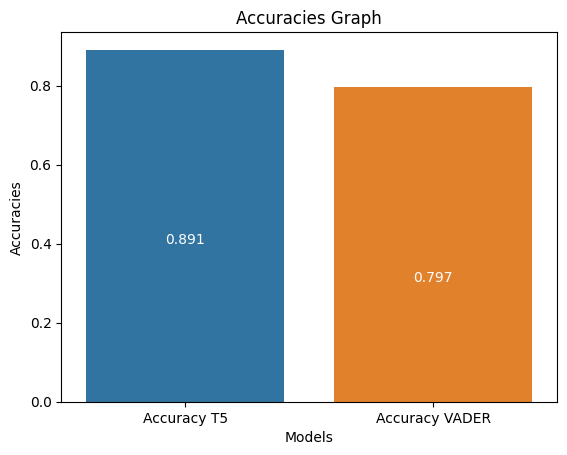

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
categories = ['Accuracy T5', 'Accuracy VADER']
values = [test_accuracy_T5, accuracy_vader]

# Create a bar plot
ax = sns.barplot(x=categories, y=values)

# Add accuracy value on each bar
for i, v in enumerate(values):
    ax.text(i, v - 0.5, '{:.3f}'.format(v), ha='center', va='bottom', color='white')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Accuracies Graph')

# Show the plot
plt.show()

T5 perfomed better than the VADER model since T5 is able to capture more long range-dependencies inside sequences of text thanks to the Attention Mechanism.